In [58]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go

from typing import Any, Tuple, Optional

import warnings
warnings.filterwarnings('ignore')

import nbimporter
from Functions import get_dollar_bars, get_returns

## Auxilary Functions

In [59]:
def pmf1(msg: Any, w: int) -> dict:
    '''
    Computes the probability mass function for a one-dim random variable (len(msg) - w occurences).
    
        Parameters:
            msg (Any): sequence with observations (usually a string)
            w (int): word length used for pmf estimation
            
        Returns:
            pmf (dict): dictionary with words as keys and their estimated probabilities as values.
    '''
    lib = {}
    if not isinstance(msg, str):
        msg = ''.join(map(str, msg))
    for i in range(w, len(msg)):
        msg_ = msg[i - w: i]
        if msg_ not in lib:
            lib[msg_] = [i - w]
        else:
            lib[msg_] = lib[msg_] + [i - w]
    length = float(len(msg) - w)
    pmf = {i: len(lib[i]) / length for i in lib}
    return pmf

In [60]:
def plug_in(msg: Any, w: int) -> Tuple[float, dict]:
    '''
    Computes the maximum likelihood estimate for the entropy rate.

        Parameters:
            msg (Any): sequence with observations (usually a string)
            w (int): word length used for pmf estimation

        Returns:
            out (float): entropy estimate
            pmf (dict): dictionary with words as keys and their estimated probabilities as values.
    '''
    pmf = pmf1(msg, w)
    out = -sum([pmf[i] * np.log2(pmf[i]) for i in pmf]) / w
    return out, pmf

In [61]:
def lempel_ziv_lib(msg: str) -> list:
    '''
    Implements the LZ algorithm to construct library.
    
        Parameters:
            msg (str): sequence with observations
            
        Returns:
            lib (list): list containing unique words
    '''
    i, lib = 1, [msg[0]]
    while i < len(msg):
        for j in range(i, len(msg)):
            msg_ = msg[i: j + 1]
            if msg_ not in lib:
                lib.append(msg_)
                break
        i = j + 1
    return lib

In [62]:
def match_length(msg: str, i: int, n: int) -> Tuple[int, str]:
    '''
    Computes the length of the longest match.
    
        Parameters:
            msg (str): sequence with observations
            i (int): position before which we look for a match
            n (int): size of the window for searching for a match
            
        Returns:
            len(subS) + 1 (int): length of the match + 1
            subS (str): matched substring
    '''
    subS = ''
    for l in range(n):
        msg1 = msg[i: i + 1 + l]
        for j in range(i - n, i):
            msg0 = msg[j: j + 1 + l]
            if msg1 == msg0:
                subS = msg1
                break
    return len(subS) + 1, subS

In [63]:
def konto(msg: Any, window: Optional[int] = None) -> dict:
    '''
    Kontoyiannis' LZ entropy estimate, 2013 version (centered window). Inverse of the avg length of the shortest
    non redundant substring. If non redundant substrings are short, the text is highly entropic.
    window=None for expanding window , in which case len(msg)%2=0.
    If the end of the message is more relevant, try conto(msg[::-1]).
    
        Parameters:
            msg (Any): sequence with observations (usually a string)
            window (Optional[int]): winodw size for constant window
            
        Returns:
            out (dict): dictionary with results
    '''
    out = {'num': 0, 'sum': 0, 'subS': []}
    if not isinstance(msg, str):
        msg = ''.join(map(str, msg))
    if window is None:
        points = range(1, len(msg) // 2 + 1)
    else:
        window = min(window, len(msg) // 2)
        points = range(window, len(msg) - window + 1)
    for i in points:
        if window is None:
            l, msg_ = match_length(msg, i, i)
            out['sum'] += np.log2(i + 1) / l    # to avoid Doeblin condition
        else:
            l, msg_ = match_length(msg, i, window)
            out['sum'] += np.log2(window + 1) / l    # to avoid Doeblin condition
        out['subS'].append(msg_)
        out['num'] += 1
    out['h'] = out['sum'] / out['num']
    out['r'] = 1 - out['h'] / np.log2(len(msg))    # redundancy, 0 <= r <= 1
    return out

## Exercises

Firstly, I download the data, transform it into dollar bars and calculate returns.

In [64]:
data = pd.read_csv('sp10-19.csv')
dollar_bars = get_dollar_bars(data['price'].values, data['volume'].values, data['datetime'].values, 50000)
dollar_bars_df = pd.DataFrame(data=dollar_bars[:, 1:], index=dollar_bars[:, 0],
                           columns=['open', 'high', 'low', 'close', 'volume'])
dollar_bars_df = dollar_bars_df[~dollar_bars_df.index.duplicated(keep='first')]
ret = get_returns(dollar_bars)
ret.head()

2010-01-03 17:04:29    0.000179
2010-01-03 17:15:11    0.000538
2010-01-03 17:52:34    0.000090
2010-01-03 18:47:00    0.000269
2010-01-03 19:43:18   -0.000538
dtype: float64

### 1. Quantization & Entropy

1.1 Binary quantization:

In [65]:
ret_binary = (ret >= 0).astype(int)
message = ''.join(map(str, ret_binary.values))

In [66]:
print(f'Plug-In Entropy estimation: {plug_in(msg=message, w=100)[0]}')
konto_est = konto(msg=message, window=100)['h']
print(f'Konto\'s Entropy estimation: {konto_est}')

Plug-In Entropy estimation: 0.1631972503574526
Konto's Entropy estimation: 0.8686435204826694


1.2 Quantile encoding:

In [67]:
ret_quantile = pd.qcut(ret, q=10, labels=range(10))
message = ''.join(map(str, ret_quantile.values))

In [68]:
print(f'Plug-In Entropy estimation: {plug_in(msg=message, w=100)[0]}')
konto_est = konto(msg=message, window=100)['h']
print(f'Konto\'s Entropy estimation: {konto_est}')

Plug-In Entropy estimation: 0.1631972503574526
Konto's Entropy estimation: 2.479176924111044


1.3 Sigma encoding:

In [69]:
def generate_buckets(series: pd.Series, sigma: float) -> list:
    '''
    Generates a list of segments corresponding to each bucket.
    
        Parameters:
            series (pd.Series): series with data
            sigma (float): size of each segment
            
        Returns:
            segments (list): list with segments
    '''
    segments = []
    cnt = 1
    while series.min() + (cnt - 1) * sigma < series.max():
        segments.append([series.min() + (cnt - 1) * sigma, series.min() + cnt * sigma])
        cnt += 1
    return segments


def encode_single_obs(obs: float, segments: list) -> str:
    '''
    Given a number, returns its code according to the generated segments using sigma encoding.
    NOTE: for encoding, I use sumbols starting from 48th ASCII code ('0').
    
        Parameters:
            obs (float): observation value
            segments (list): list with buckets boundaries
            
        Returns:
            code (str): encoded observation
    '''
    for i in range(len(segments)):
        if segments[i][0] <= obs < segments[i][1]:
            code = chr(48 + i)
            return code

In [70]:
segments = generate_buckets(series=ret, sigma=ret.std())
ret_sigma = ret.apply(lambda obs: encode_single_obs(obs=obs, segments=segments))
message = ''.join(map(str, ret_sigma.values))

In [71]:
print(f'Plug-In Entropy estimation: {plug_in(msg=message, w=100)[0]}')
konto_est = konto(msg=message, window=100)['h']
print(f'Konto\'s Entropy estimation: {konto_est}')

Plug-In Entropy estimation: 0.1631972503574526
Konto's Entropy estimation: 1.3696225581174863


### 2. Normal Distribution

The true entropy of the standord normal distribution equals
$$\dfrac{1}{2}\log{(2\pi e)}\approx1.42$$

Now let's make some samples and estimate the entropy:

In [72]:
samples = np.random.normal(size=1000)
samples_quantile = pd.qcut(samples, q=8, labels=range(8))
message = ''.join(map(str, samples_quantile))

The Plug-In method:

In [73]:
print(f'Plug-In Entropy estimation: {plug_in(msg=message, w=10)[0]}')

Plug-In Entropy estimation: 0.9951284714966828


The Kontoyiannis method:

In [74]:
konto_est_10 = konto(msg=message, window=10)['h']
print(f'Konto\'s Entropy estimation (window size 10): {konto_est_10}')
konto_est_100 = konto(msg=message, window=100)['h']
print(f'Konto\'s Entropy estimation (window size 100): {konto_est_100}')

Konto's Entropy estimation (window size 10): 2.0976991828199743
Konto's Entropy estimation (window size 100): 2.348799781077258


### 3. Entropy of a Stochastic Process

Here we define a process
$$y_t=\rho y_{t-1}+x_t,$$ where $\rho=0.5$, $y_0=0$, and $x_t$ are the observations generated from the standard normal distribution in the previous exercise.

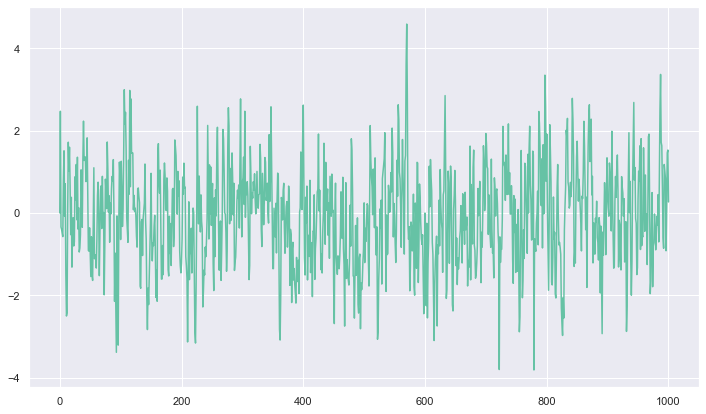

In [75]:
y = np.array([0])
for i in range(1, len(samples) + 1):
    y = np.append(y, 0.5 * y[-1] + samples[i - 1])

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(y)
fig.show()

Now we quantize the derived series.

In [76]:
y_quantile = pd.qcut(y, q=8, labels=range(8))
message = ''.join(map(str, y_quantile))

The Plug-In method:

In [77]:
print(f'Plug-In Entropy estimation: {plug_in(msg=message, w=10)[0]}')

Plug-In Entropy estimation: 0.9952741247186501


The Kontoyiannis method:

In [78]:
konto_est_10 = konto(msg=message, window=10)['h']
print(f'Konto\'s Entropy estimation (window size 10): {konto_est_10}')
konto_est_100 = konto(msg=message, window=100)['h']
print(f'Konto\'s Entropy estimation (window size 100): {konto_est_100}')

Konto's Entropy estimation (window size 10): 2.042812656036942
Konto's Entropy estimation (window size 100): 2.2644521115442293
